In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("awsaf49/brats20-dataset-training-validation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brats20-dataset-training-validation' dataset.
Path to dataset files: /kaggle/input/brats20-dataset-training-validation


In [3]:
import os, glob


if 'path' not in globals():

    path = "/kaggle/input/brats20-dataset-training-validation"


DATASET_ROOT = path
TRAIN_DATASET_PATH = os.path.join(DATASET_ROOT, "BraTS2020_TrainingData", "MICCAI_BraTS2020_TrainingData")
VAL_DATASET_PATH   = os.path.join(DATASET_ROOT, "BraTS2020_ValidationData", "MICCAI_BraTS2020_ValidationData")

print("TRAIN_DATASET_PATH ->", TRAIN_DATASET_PATH, "| exists:", os.path.isdir(TRAIN_DATASET_PATH))
print("VAL_DATASET_PATH   ->", VAL_DATASET_PATH,   "| exists:", os.path.isdir(VAL_DATASET_PATH))



TRAIN_DATASET_PATH -> /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData | exists: True
VAL_DATASET_PATH   -> /kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData | exists: True


In [4]:
import os
all_ids = [f for f in os.listdir(TRAIN_DATASET_PATH) if os.path.isdir(os.path.join(TRAIN_DATASET_PATH, f))]
print("Total subjects:", len(all_ids))


Total subjects: 369


In [5]:
import os, glob

def missing_modalities(train_root, sid):
    d = os.path.join(train_root, sid)
    miss = []
    for mod in ["flair", "t1ce", "seg"]:
        pat = os.path.join(d, f"{sid}_{mod}.nii*")  # nii یا nii.gz
        if len(glob.glob(pat)) == 0:
            miss.append(mod)
    return miss

bad_ids = [sid for sid in all_ids if missing_modalities(TRAIN_DATASET_PATH, sid)]
print("Bad subjects:", len(bad_ids))
print("Examples:", bad_ids[:10])


Bad subjects: 1
Examples: ['BraTS20_Training_355']


In [6]:
def missing_modalities(train_root, sid):
    import os, glob
    d = os.path.join(train_root, sid)
    miss = []
    for mod in ["flair", "t1ce", "seg"]:
        pat = os.path.join(d, f"{sid}_{mod}.nii*")  # nii یا nii.gz
        if len(glob.glob(pat)) == 0:
            miss.append(mod)
    return miss

print("355 missing:", missing_modalities(TRAIN_DATASET_PATH, "BraTS20_Training_355"))


355 missing: ['seg']


In [7]:
import os

# List first 20 files to check structure
for root, dirs, files in os.walk("/kaggle/input/brats20-dataset-training-validation"):
    for f in files[:20]:
        print(os.path.join(root, f))
    break


In [8]:
import nibabel as nib
import glob

# Find all .nii.gz files
nii_files = glob.glob("/kaggle/input/brats20-dataset-training-validation/**/*.nii*", recursive=True)
print("Number of NIfTI files:", len(nii_files))

# Load one image to inspect
img = nib.load(nii_files[0])
data = img.get_fdata()
print("Shape:", data.shape)


Number of NIfTI files: 2345
Shape: (240, 240, 155)


In [9]:
! pip install nilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 103.8 MB/s eta 0:00:00


In [10]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif
import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras import layers
from tensorflow.keras import preprocessing

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

  Cloning https://github.com/miykael/gif_your_nifti to /tmp/pip-req-build-cll31ct7
  Running command git clone --filter=blob:none --quiet https://github.com/miykael/gif_your_nifti /tmp/pip-req-build-cll31ct7
  Resolved https://github.com/miykael/gif_your_nifti to commit 55c09c42921f4871cf43f63a303ab420a92a4f03
  Preparing metadata (setup.py) ... done
  Created wheel for gif_your_nifti: filename=gif_your_nifti-0.2.2-py3-none-any.whl size=6632 sha256=cf85d3a4573095aedd88558398a19dfb952a789aa6d07b9ef3ce67d5f59f45c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-0tf0fhgb/wheels/ac/95/84/49a6110ca4538c61d1cd21008bbb96828e74d3d8163f50887e
Successfully built gif_your_nifti


In [11]:
# DEFINE seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include

In [12]:
# --- Step 1A: Inspect folder structure & pick a sample subject ---

import os, glob

# 1) Correct base paths for Kaggle in Colab
DATASET_ROOT = "/kaggle/input/brats20-dataset-training-validation"
TRAIN_DATASET_PATH = os.path.join(DATASET_ROOT, "BraTS2020_TrainingData", "MICCAI_BraTS2020_TrainingData")
VAL_DATASET_PATH   = os.path.join(DATASET_ROOT, "BraTS2020_ValidationData", "MICCAI_BraTS2020_ValidationData")

print("TRAIN_DATASET_PATH:", TRAIN_DATASET_PATH)
print("Exists?", os.path.exists(TRAIN_DATASET_PATH))

# 2) List a few subject folders to confirm names like 'BraTS20_Training_001'
subjects = sorted([d for d in glob.glob(os.path.join(TRAIN_DATASET_PATH, "BraTS20_Training_*")) if os.path.isdir(d)])
print("Found subjects:", len(subjects))
print("Examples:", subjects[:3])

# 3) Pick one subject (first one) safely
sample = subjects[0]
print("Sample subject:", sample)

# 4) For this subject, list available files (to check extensions)
files = sorted(glob.glob(os.path.join(sample, "*")))
print("Files in sample:", [os.path.basename(f) for f in files])


TRAIN_DATASET_PATH: /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData
Exists? True
Found subjects: 369
Examples: ['/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001', '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002', '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003']
Sample subject: /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001
Files in sample: ['BraTS20_Training_001_flair.nii', 'BraTS20_Training_001_seg.nii', 'BraTS20_Training_001_t1.nii', 'BraTS20_Training_001_t1ce.nii', 'BraTS20_Training_001_t2.nii']


Using files:
  FLAIR: /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii
  T1   : /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii
  T1ce : /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii
  T2   : /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii
  SEG  : /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii
Shapes (H, W, Z): (240, 240, 155) (240, 240, 155) (240, 240, 155) (240, 240, 155) (240, 240, 155)
Chosen z slice: 77


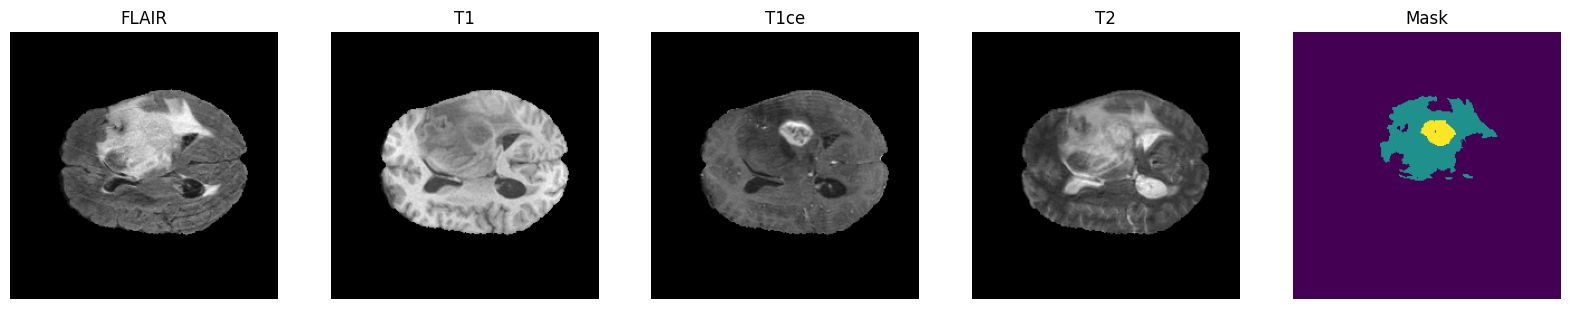

In [13]:
# --- Step 1B: Robust loader that works for .nii or .nii.gz and plots slices ---

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def find_modality(path_no_ext):
    """
    Try to resolve .nii.gz or .nii for a given 'path without extension'.
    Returns the existing full path, or raises FileNotFoundError.
    """
    candidates = [path_no_ext + ".nii.gz", path_no_ext + ".nii"]
    for c in candidates:
        if os.path.exists(c):
            return c
    raise FileNotFoundError("Neither .nii.gz nor .nii found for: " + path_no_ext)

# 1) Build base name for the chosen subject
#    e.g., sample = .../BraTS20_Training_001
subject_id = os.path.basename(sample)  # -> 'BraTS20_Training_001'
base = os.path.join(sample, subject_id)  # -> .../BraTS20_Training_001/BraTS20_Training_001

# 2) Resolve full paths for each modality and label
flair_fp = find_modality(base + "_flair")
t1_fp    = find_modality(base + "_t1")
t1ce_fp  = find_modality(base + "_t1ce")
t2_fp    = find_modality(base + "_t2")
seg_fp   = find_modality(base + "_seg")

print("Using files:")
print("  FLAIR:", flair_fp)
print("  T1   :", t1_fp)
print("  T1ce :", t1ce_fp)
print("  T2   :", t2_fp)
print("  SEG  :", seg_fp)

# 3) Load arrays
img_flair = nib.load(flair_fp).get_fdata()
img_t1    = nib.load(t1_fp).get_fdata()
img_t1ce  = nib.load(t1ce_fp).get_fdata()
img_t2    = nib.load(t2_fp).get_fdata()
mask      = nib.load(seg_fp).get_fdata()

# 4) Pick a slice index near the middle along the last axis (z)
z = img_flair.shape[2] // 2  # use axis 2 for axial
print("Shapes (H, W, Z):", img_flair.shape, img_t1.shape, img_t1ce.shape, img_t2.shape, mask.shape)
print("Chosen z slice:", z)

# 5) Plot them
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
axes[0].imshow(img_flair[:, :, z], cmap="gray"); axes[0].set_title("FLAIR")
axes[1].imshow(img_t1[:, :, z],    cmap="gray"); axes[1].set_title("T1")
axes[2].imshow(img_t1ce[:, :, z],  cmap="gray"); axes[2].set_title("T1ce")
axes[3].imshow(img_t2[:, :, z],    cmap="gray"); axes[3].set_title("T2")
# For mask, use a discrete colormap; but simple imshow is fine for now
axes[4].imshow(mask[:, :, z]);      axes[4].set_title("Mask")
for ax in axes: ax.axis("off")
plt.show()


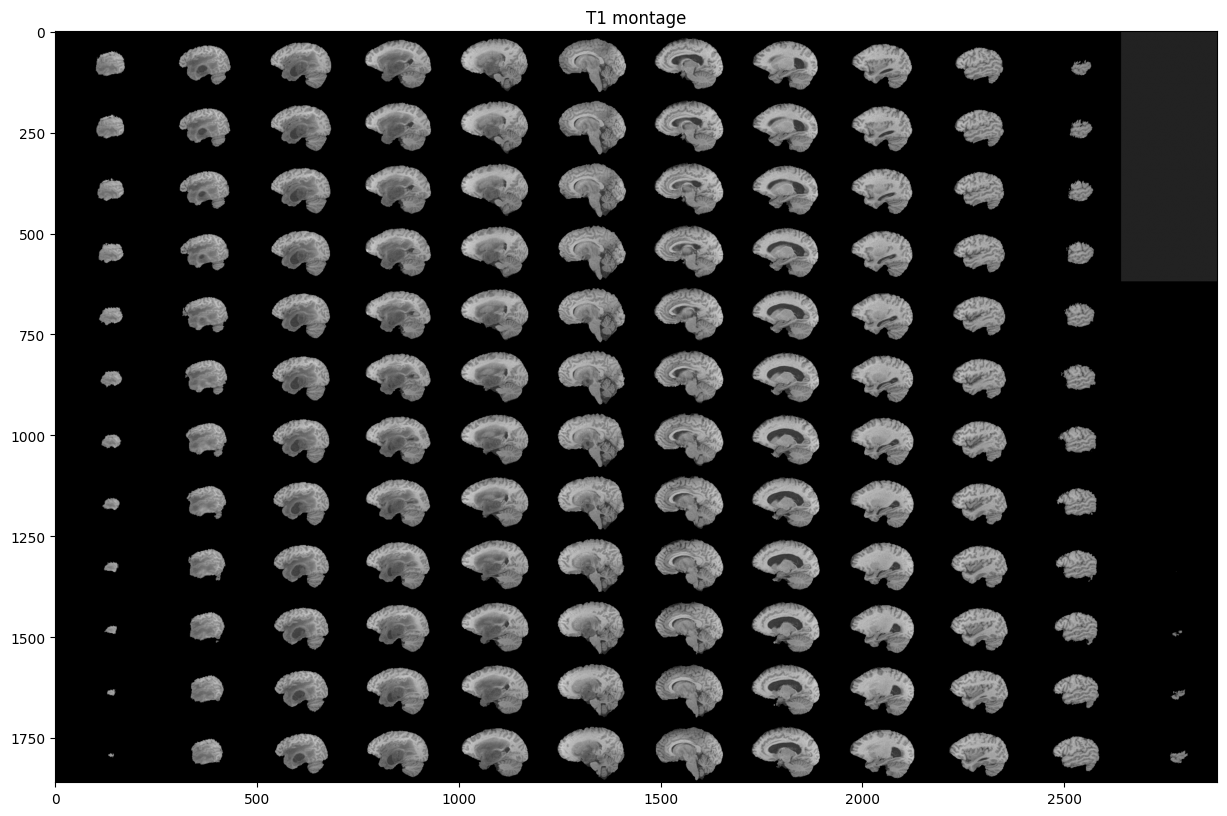

In [14]:
from skimage.util import montage
from scipy.ndimage import rotate
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(img_t1[50:-50,:,:]), 90, reshape=True), cmap='gray')
ax1.set_title("T1 montage")
plt.show()


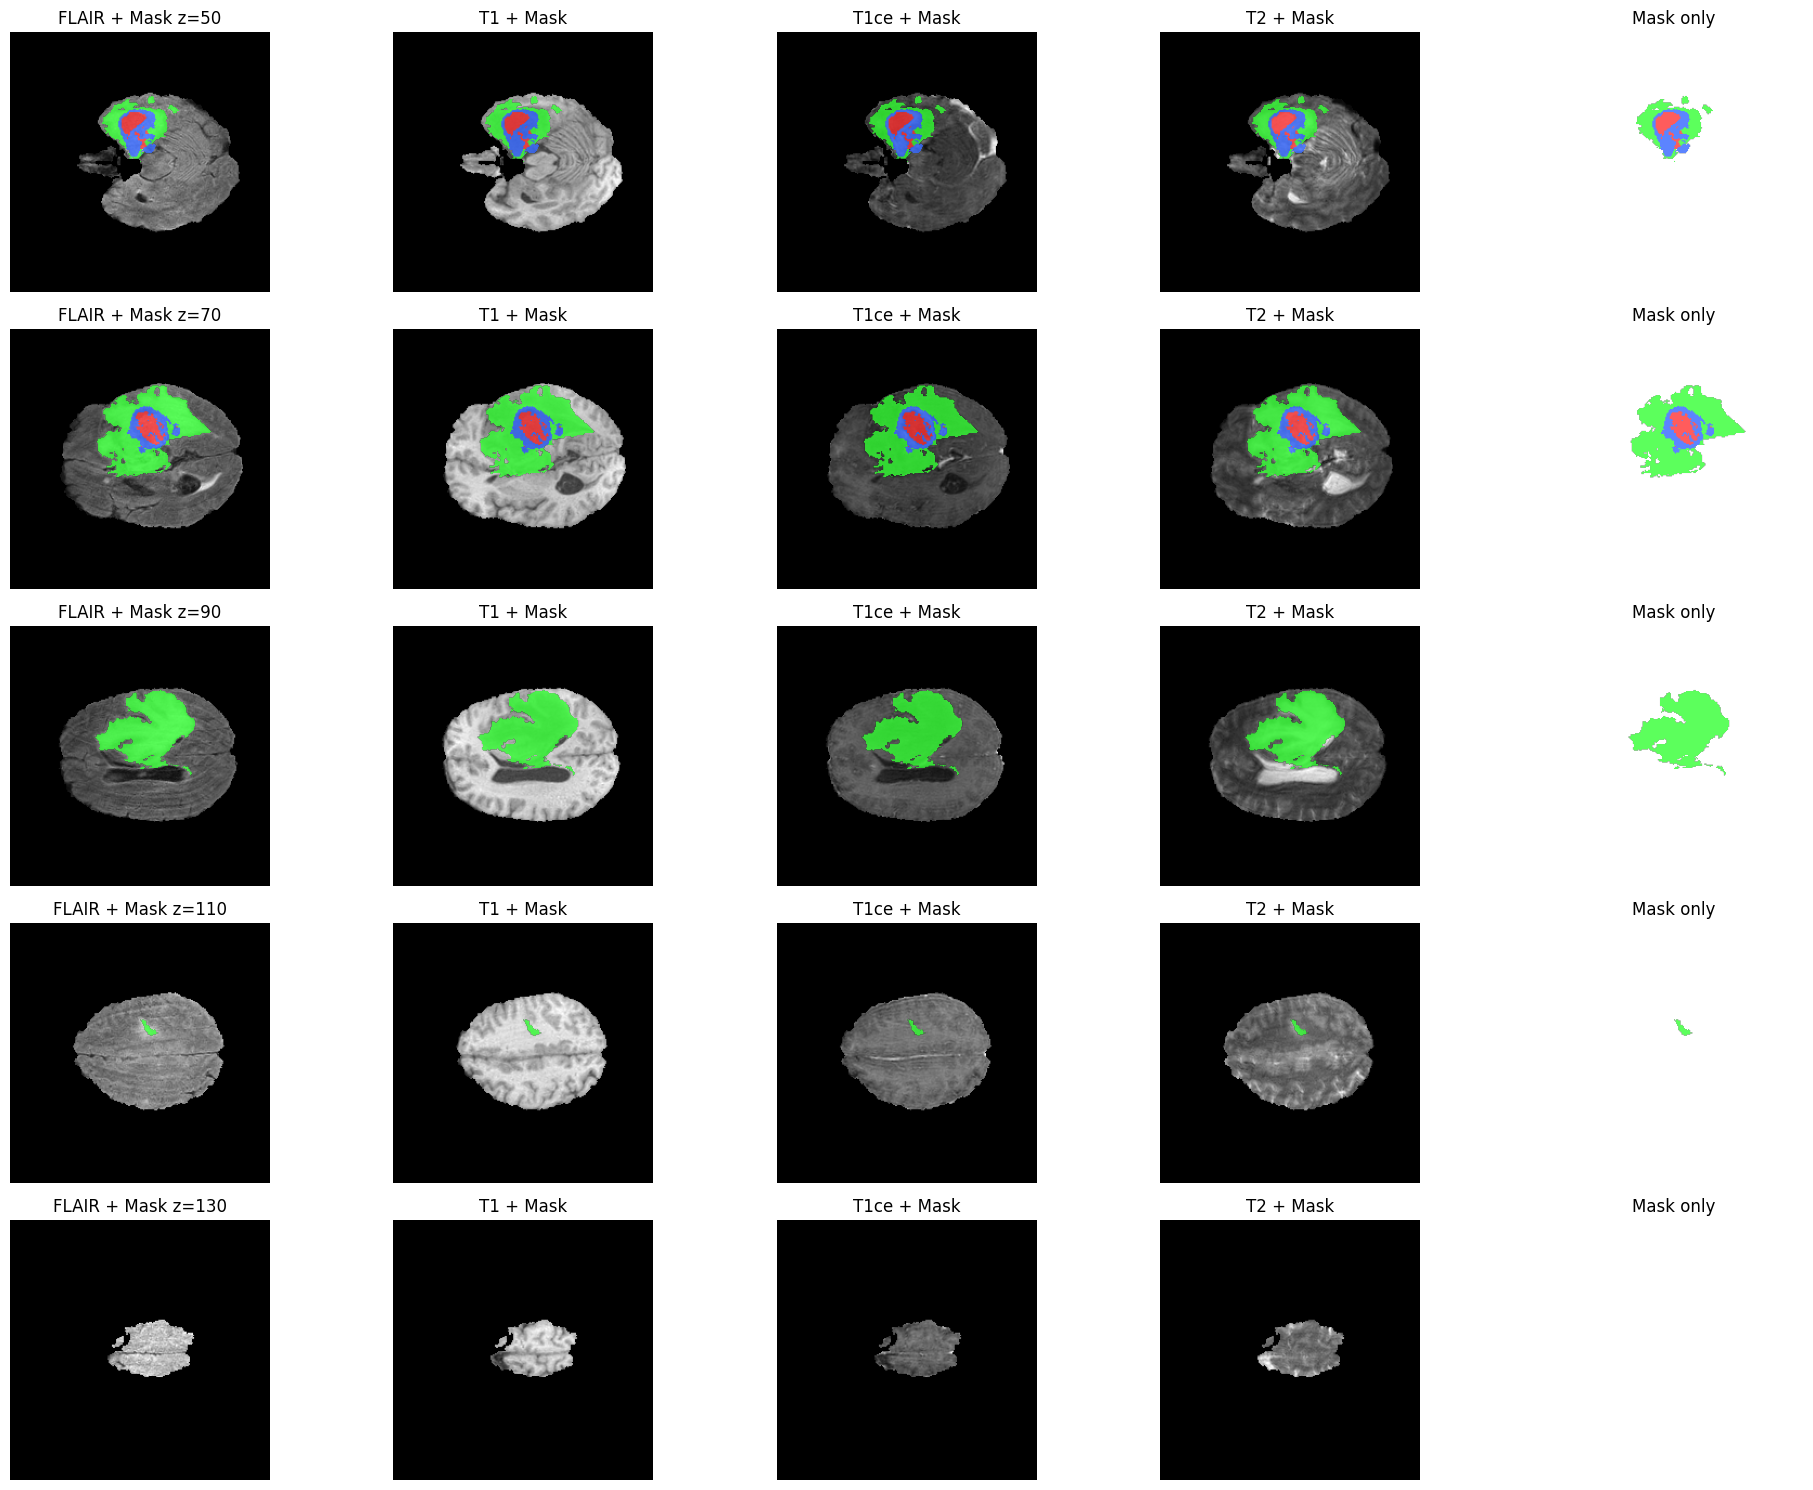

Classes shown:
0 = background (transparent)
1 = NECROTIC/CORE  |  2 = EDEMA  |  3 = ENHANCING (original 4)


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# --- Prepare a clean mask for display: map label 4 -> 3
mask_disp = mask.copy()
mask_disp[mask_disp == 4] = 3

# --- Build a discrete colormap for 4 classes: 0 bg + 3 tumor classes
# colors: background (transparent), class1, class2, class3
cmap = ListedColormap([
    (0, 0, 0, 0.0),      # class 0: fully transparent
    (1.0, 0.2, 0.2, 0.8),# class 1: red-ish
    (0.2, 1.0, 0.2, 0.8),# class 2: green-ish
    (0.2, 0.4, 1.0, 0.8) # class 3: blue-ish
])
norm = BoundaryNorm(boundaries=[-0.5,0.5,1.5,2.5,3.5], ncolors=cmap.N)

# --- Choose some z slices to visualize
slices = [50, 70, 90, 110, 130]  # you can change them

fig, axes = plt.subplots(len(slices), 5, figsize=(20, 3*len(slices)))
for i, z in enumerate(slices):
    # 4 modalities in gray
    axes[i,0].imshow(img_flair[:,:,z], cmap="gray"); axes[i,0].imshow(mask_disp[:,:,z], cmap=cmap, norm=norm); axes[i,0].set_title(f"FLAIR + Mask z={z}")
    axes[i,1].imshow(img_t1[:,:,z],    cmap="gray"); axes[i,1].imshow(mask_disp[:,:,z], cmap=cmap, norm=norm); axes[i,1].set_title("T1 + Mask")
    axes[i,2].imshow(img_t1ce[:,:,z],  cmap="gray"); axes[i,2].imshow(mask_disp[:,:,z], cmap=cmap, norm=norm); axes[i,2].set_title("T1ce + Mask")
    axes[i,3].imshow(img_t2[:,:,z],    cmap="gray"); axes[i,3].imshow(mask_disp[:,:,z], cmap=cmap, norm=norm); axes[i,3].set_title("T2 + Mask")
    # raw mask alone
    axes[i,4].imshow(mask_disp[:,:,z], cmap=cmap, norm=norm); axes[i,4].set_title("Mask only")
    for j in range(5): axes[i,j].axis("off")

plt.tight_layout()
plt.show()

# --- Optional: small legend (text)
print("Classes shown:")
print("0 = background (transparent)")
print("1 = NECROTIC/CORE  |  2 = EDEMA  |  3 = ENHANCING (original 4)")


In [16]:
# --- Make an animated GIF from the FLAIR volume  ---

import numpy as np
import imageio.v2 as imageio  # imageio for writing GIFs

# 1) Use the file path we already resolved earlier
#    (from Step 1B): flair_fp points to ..._flair.nii.gz (or .nii)
print("FLAIR file:", flair_fp)

# 2) We already loaded it into img_flair. If not, uncomment next two lines:
# import nibabel as nib
# img_flair = nib.load(flair_fp).get_fdata()

# 3) Normalize each slice to 0..255 for visualization
vol = img_flair.astype(np.float32)
vmin, vmax = np.percentile(vol, [1, 99])  # robust min/max
vol = np.clip((vol - vmin) / (vmax - vmin + 1e-8), 0, 1)

# 4) Choose a slice range (avoid empty ends)
z_start, z_end = 20, vol.shape[2] - 20
frames = [(vol[:, :, z] * 255).astype(np.uint8) for z in range(z_start, z_end)]

# 5) Save GIF (duration controls speed; smaller = faster)
out_gif = "/content/BraTS20_001_flair.gif"
imageio.mimsave(out_gif, frames, duration=0.05)
print("Saved:", out_gif)


FLAIR file: /kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii
Saved: /content/BraTS20_001_flair.gif


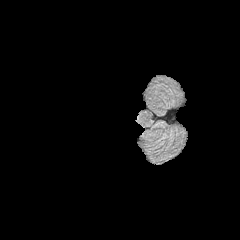

In [17]:
from IPython.display import Image, display

out_gif = "/content/BraTS20_001_flair.gif"  # same path you printed
display(Image(filename=out_gif))


In [18]:
    !pip -q install nilearn


In [25]:
import os, glob
from nilearn import image as nlimg  # loader for NIfTI

# pick a subject folder to visualize
sid = train_ids[0] if 'train_ids' in globals() and len(train_ids) else "BraTS20_Training_001"

def find_modality(root, sid, mod):
    # returns the first match for .nii or .nii.gz
    hits = glob.glob(os.path.join(root, sid, f"{sid}_{mod}.nii*"))
    if not hits:
        raise FileNotFoundError(f"Missing modality '{mod}' for subject {sid}")
    return hits[0]

# --- define niimg (what your plotting code needs) ---
niimg  = nlimg.load_img(find_modality(TRAIN_DATASET_PATH, sid, "flair"))

# (optional) if your code also uses nimask in plot_roi:
nimask = nlimg.load_img(find_modality(TRAIN_DATASET_PATH, sid, "seg"))


/tmp/ipython-input-1330560042.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


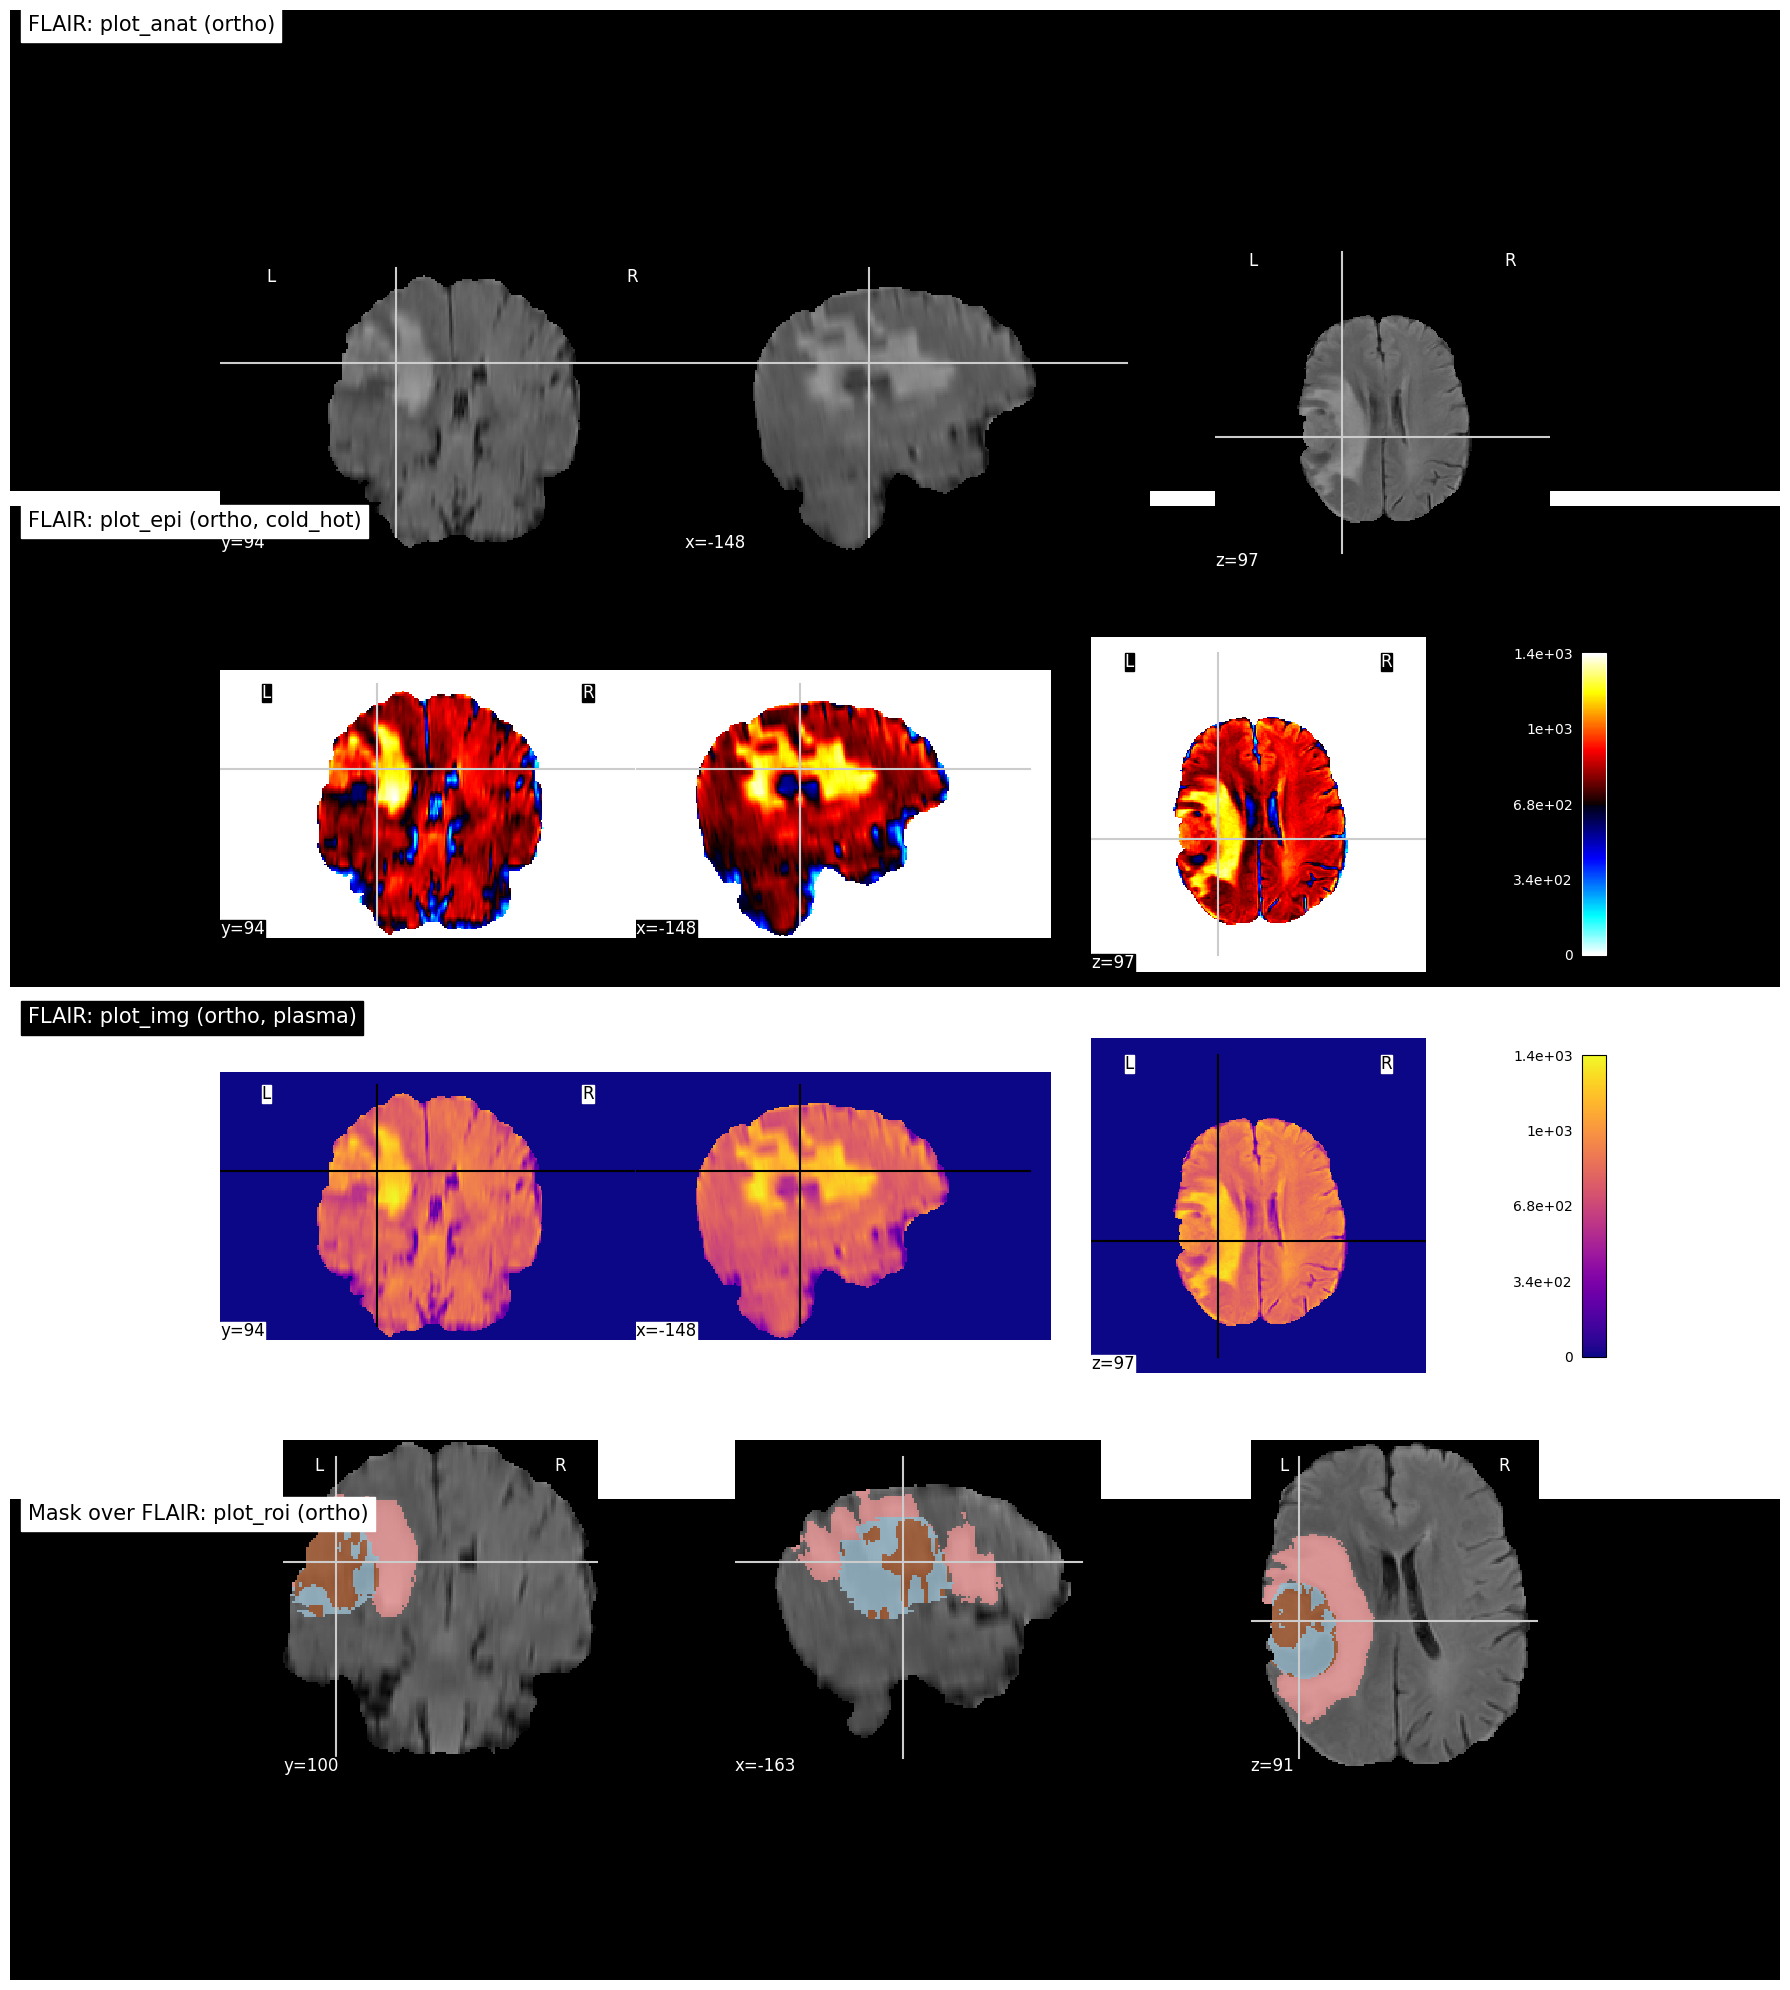

In [26]:
# Match Kaggle-styled panels: orthogonal crosshair views, colored colormaps, colorbars

from nilearn import plotting as nlplt
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, figsize=(18, 20))

# 1) Anatomical-style, orthogonal, crosshair visible
nlplt.plot_anat(
    niimg,
    title='FLAIR: plot_anat (ortho)',
    axes=axes[0],
    display_mode='ortho',  # 3 views (x, y, z)
    annotate=True,
    draw_cross=True,       # show crosshair like in the notebook
    colorbar=False
)

# 2) EPI-style, orthogonal, colored colormap + colorbar
nlplt.plot_epi(
    niimg,
    title='FLAIR: plot_epi (ortho, cold_hot)',
    axes=axes[1],
    display_mode='ortho',
    annotate=True,
    draw_cross=True,
    cmap='cold_hot',       # heatmap-like look
    colorbar=True,
    black_bg=True          # dark background like typical functional plots
)

# 3) Generic image, orthogonal, colored colormap + colorbar
nlplt.plot_img(
    niimg,
    title='FLAIR: plot_img (ortho, plasma)',
    axes=axes[2],
    display_mode='ortho',
    annotate=True,
    draw_cross=True,
    cmap='plasma',         # vivid color map
    colorbar=True
)

# 4) ROI overlay (mask) on FLAIR, orthogonal
nlplt.plot_roi(
    nimask,
    bg_img=niimg,
    title='Mask over FLAIR: plot_roi (ortho)',
    axes=axes[3],
    display_mode='ortho',
    annotate=True,
    draw_cross=True,
    cmap='Paired',         # discrete colors for classes
    colorbar=False
)

plt.tight_layout()
plt.show()


In [28]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss



# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision


# Computing Sensitivity
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [29]:
IMG_SIZE=128


In [30]:
# ===== U-Net Architecture (Keras / TensorFlow) =====
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import (Conv2D, Conv2DTranspose, MaxPooling2D,
                                     BatchNormalization, Activation, Concatenate,
                                     SpatialDropout2D)

def conv_block(x, filters, ker_init='he_normal'):
    """Conv -> BN -> ReLU -> Conv -> BN -> ReLU"""
    x = Conv2D(filters, 3, padding='same', kernel_initializer=ker_init, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, 3, padding='same', kernel_initializer=ker_init, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def build_unet_bn_full(img_size=256, in_channels=4, n_classes=4, ker_init='he_normal', dropout=0.2):
    """
    Full U-Net with:
      - Double Conv blocks + BatchNorm + ReLU
      - MaxPooling down, ConvTranspose up
      - SpatialDropout2D at bottleneck
      - Softmax head (n_classes)
    """
    inputs = Input((img_size, img_size, in_channels))

    # ---------------- Encoder (Down path) ----------------
    # Level 1:  HxW -> HxW, 32ch
    c1 = conv_block(inputs, 32, ker_init)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)     # H/2 x W/2

    # Level 2:  H/2 x W/2, 64ch
    c2 = conv_block(p1, 64, ker_init)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)     # H/4 x W/4

    # Level 3:  H/4 x W/4, 128ch
    c3 = conv_block(p2, 128, ker_init)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)     # H/8 x W/8

    # Level 4:  H/8 x W/8, 256ch
    c4 = conv_block(p3, 256, ker_init)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)     # H/16 x W/16

    # ---------------- Bottleneck ----------------
    b = conv_block(p4, 512, ker_init)           # H/16 x W/16, 512ch
    b = SpatialDropout2D(dropout)(b)

    # ---------------- Decoder (Up path) ----------------
    # Up 1: H/16 -> H/8, concat with c4, then 256ch
    u1 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same', kernel_initializer=ker_init)(b)
    u1 = Concatenate(axis=-1)([u1, c4])
    c5 = conv_block(u1, 256, ker_init)

    # Up 2: H/8 -> H/4, concat with c3, then 128ch
    u2 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same', kernel_initializer=ker_init)(c5)
    u2 = Concatenate(axis=-1)([u2, c3])
    c6 = conv_block(u2, 128, ker_init)

    # Up 3: H/4 -> H/2, concat with c2, then 64ch
    u3 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same', kernel_initializer=ker_init)(c6)
    u3 = Concatenate(axis=-1)([u3, c2])
    c7 = conv_block(u3, 64, ker_init)

    # Up 4: H/2 -> H, concat with c1, then 32ch
    u4 = Conv2DTranspose(32, kernel_size=2, strides=2, padding='same', kernel_initializer=ker_init)(c7)
    u4 = Concatenate(axis=-1)([u4, c1])
    c8 = conv_block(u4, 32, ker_init)

    # ---------------- Head ----------------
    outputs = Conv2D(n_classes, kernel_size=1, activation='softmax')(c8)

    return Model(inputs, outputs, name="UNet_Improved_BN")

# ===== Example usage =====
# For BraTS 2D slices with 4 modalities as channels:
# model = build_unet_bn_full(img_size=256, in_channels=4, n_classes=4, ker_init='he_normal', dropout=0.2)
# model.summary(line_length=120)



In [31]:
model = build_unet_bn_full(img_size=128, in_channels=4, n_classes=4)


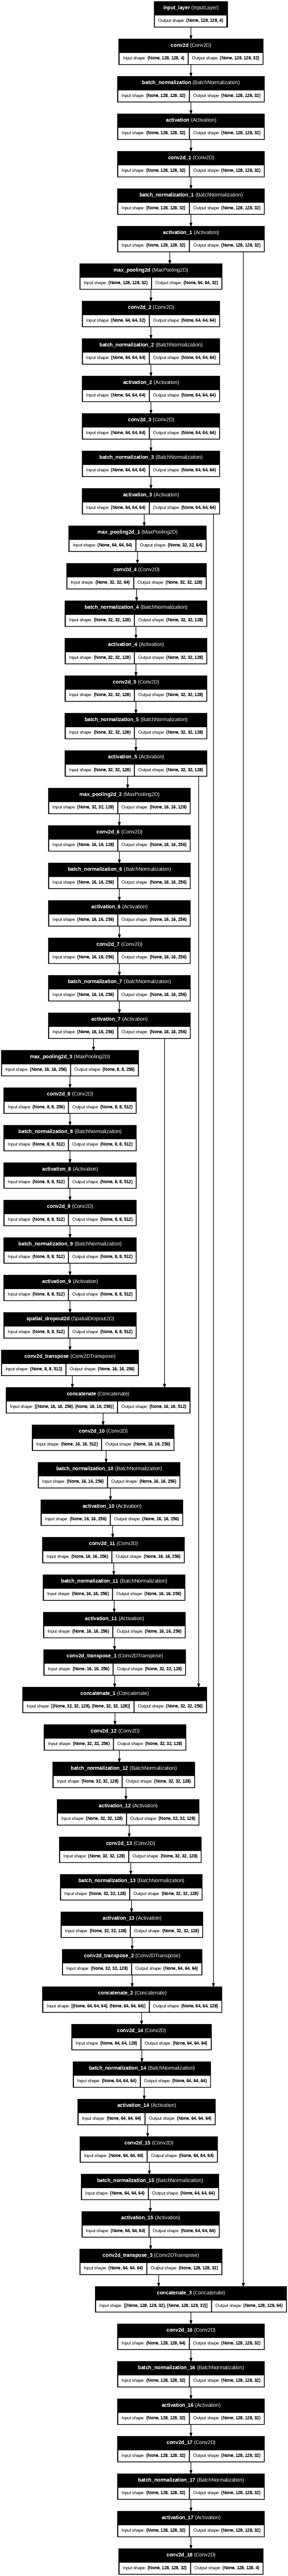

In [32]:
from tensorflow.keras.utils import plot_model

plot_model(model,
           show_shapes=True,
           show_dtype=False,
           show_layer_names=True,
           rankdir='TB',
           expand_nested=False,
           dpi=70)


In [33]:
from sklearn.model_selection import train_test_split
import os

all_ids = sorted([d for d in os.listdir(TRAIN_DATASET_PATH)
                  if os.path.isdir(os.path.join(TRAIN_DATASET_PATH, d))])

# 70% train, 15% val, 15% test
train_ids, temp_ids = train_test_split(all_ids, test_size=0.30, random_state=42, shuffle=True)
val_ids,   test_ids = train_test_split(temp_ids, test_size=0.50, random_state=42, shuffle=True)

print("Train:", len(train_ids), "Val:", len(val_ids), "Test:", len(test_ids))


Train: 258 Val: 55 Test: 56


In [34]:
import os, glob, numpy as np, cv2, nibabel as nib, tensorflow as tf
from tensorflow import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(
        self,
        list_IDs,
        train_path,                 # dataset root for subjects
        dim=(128, 128),
        batch_size=1,
        n_channels=4,
        volume_slices=100,
        volume_start=22,
        shuffle=True,
        do_normalize=True,
        do_aug=False
    ):
        self.list_IDs      = list_IDs
        self.train_path    = train_path
        self.dim           = dim
        self.batch_size    = batch_size
        self.n_channels    = n_channels
        self.volume_slices = volume_slices
        self.volume_start  = volume_start
        self.shuffle       = shuffle
        self.do_normalize  = do_normalize
        self.do_aug        = do_aug
        self.on_epoch_end()

    # ---- Keras Sequence API ----
    def __len__(self):
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        idxs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_ids = [self.list_IDs[k] for k in idxs]
        X, Y = self.__data_generation(batch_ids)
        return X, Y

    # ---- helpers ----
    @staticmethod
    def _find(path_no_ext):
        """Return first match for *.nii* (nii or nii.gz)."""
        cand = glob.glob(path_no_ext + ".nii*")
        if not cand:
            raise FileNotFoundError(f"Not found: {path_no_ext}.nii*")
        return cand[0]

    @staticmethod
    def _norm_volume(vol):
        """Robust per-volume normalization to [0,1] using 1/99 percentiles."""
        v = vol.astype(np.float32)
        lo, hi = np.percentile(v, [1, 99])
        if hi <= lo:
            vmax = v.max()
            vmin = v.min()
            if vmax <= vmin:
                return np.zeros_like(v, dtype=np.float32)
            lo, hi = vmin, vmax
        v = np.clip((v - lo) / (hi - lo + 1e-6), 0., 1.)
        return v

    def _maybe_aug2d(self, img2d):
        """Simple horizontal flip with p=0.5 if do_aug=True."""
        if not self.do_aug:
            return img2d
        if np.random.rand() < 0.5:
            img2d = np.flip(img2d, axis=1)
        return img2d

    # ---- core ----
    def __data_generation(self, batch_ids):
        H, W = self.dim
        B    = self.batch_size
        S    = self.volume_slices

        X = np.zeros((B*S, H, W, self.n_channels), dtype=np.float32)
        Y = np.zeros((B*S, H, W, 4),               dtype=np.float32)

        filled = 0  # number of samples actually filled

        for sid in batch_ids:
            try:
                case_dir = os.path.join(self.train_path, sid)
                flair_fp = self._find(os.path.join(case_dir, f"{sid}_flair"))
                t1ce_fp  = self._find(os.path.join(case_dir, f"{sid}_t1ce"))
                seg_fp   = self._find(os.path.join(case_dir, f"{sid}_seg"))

                flair = nib.load(flair_fp).get_fdata()
                t1ce  = nib.load(t1ce_fp ).get_fdata()
                seg   = nib.load(seg_fp  ).get_fdata()  # labels: 0/1/2/3/4

                if self.do_normalize:
                    flair = self._norm_volume(flair)
                    t1ce  = self._norm_volume(t1ce)

                depth = flair.shape[2]
                start = self.volume_start
                end   = min(start + S, depth)
                start = max(0, end - S)

                for z in range(start, end):
                    # images: bilinear resize; labels: nearest-neighbor resize
                    fz = cv2.resize(flair[:, :, z], (W, H), interpolation=cv2.INTER_LINEAR)
                    cz = cv2.resize(t1ce [:, :, z], (W, H), interpolation=cv2.INTER_LINEAR)

                    fz = self._maybe_aug2d(fz)
                    cz = self._maybe_aug2d(cz)

                    X[filled, :, :, 0] = fz
                    if self.n_channels >= 2:
                        X[filled, :, :, 1] = cz
                    # add more modalities here if needed (e.g., T1/T2)

                    mz = seg[:, :, z].astype(np.int32)
                    mz[mz == 4] = 3
                    mzr = cv2.resize(mz, (W, H), interpolation=cv2.INTER_NEAREST).astype(np.int32)
                    Y[filled] = tf.one_hot(mzr, depth=4, dtype=tf.float32).numpy()

                    filled += 1
                    if filled >= B*S:
                        break

            except FileNotFoundError as e:
                print(f"[WARN] Skipping {sid}: {e}")
                continue

            if filled >= B*S:
                break

        # pad if fewer than B*S were filled
        if 0 < filled < B*S:
            X[filled:] = X[: (B*S - filled)]
            Y[filled:] = Y[: (B*S - filled)]

        return X, Y



In [35]:
training_generator = DataGenerator(
    train_ids,
    train_path=TRAIN_DATASET_PATH,
    dim=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    n_channels=4,
    volume_slices=VOLUME_SLICES,
    volume_start=VOLUME_START_AT,
    shuffle=True,
    do_normalize=True,
    do_aug=False
)

valid_generator = DataGenerator(
    val_ids,
    train_path=TRAIN_DATASET_PATH,
    dim=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    n_channels=4,
    volume_slices=VOLUME_SLICES,
    volume_start=VOLUME_START_AT,
    shuffle=False,
    do_normalize=True,
    do_aug=False
)


In [36]:
from sklearn.model_selection import train_test_split

# Get all subject folder names inside training dataset
all_ids = [f for f in os.listdir(TRAIN_DATASET_PATH) if os.path.isdir(os.path.join(TRAIN_DATASET_PATH, f))]

print("Total subjects found:", len(all_ids))

# Split into train (70%), validation (15%), test (15%)
train_ids, temp_ids = train_test_split(all_ids, test_size=0.3, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

print("Train:", len(train_ids))
print("Validation:", len(val_ids))
print("Test:", len(test_ids))


Total subjects found: 369
Train: 258
Validation: 55
Test: 56


In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, TensorBoard
import os, datetime

log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks = [
    ModelCheckpoint(
        filepath="unet_best.weights.h5",   # <-- fixed extension
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,            # weights-only format requires .weights.h5
        mode="min",
        verbose=1
    ),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),
    CSVLogger("training_log.csv", append=False),
    TensorBoard(log_dir=log_dir, histogram_freq=0),
]




In [38]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, CSVLogger, TensorBoard
import os, datetime

log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks = [
    # choose ONE of these two styles:

    # (A) save weights only (small file)
    ModelCheckpoint(
        filepath="unet_best.weights.h5",
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,  # requires .weights.h5
        mode="min",
        verbose=1
    ),

    # lr scheduler
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1),

    # early stop
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1),

    # logs
    CSVLogger("training_log.csv", append=False),
    TensorBoard(log_dir=log_dir, histogram_freq=0),
]


In [39]:
# ==== Metrics & Losses for multi-class segmentation (one-hot labels/preds) ====
import tensorflow as tf
K   = tf.keras.backend
EPS = tf.keras.backend.epsilon()

# ---------------- Dice ----------------
def dice_coef(y_true, y_pred, smooth=1.0):
    yt = K.flatten(y_true); yp = K.flatten(y_pred)
    inter = K.sum(yt * yp); denom = K.sum(yt) + K.sum(yp)
    return (2.*inter + smooth) / (denom + smooth)

def dice_coef_class(c):
    def _dice(y_true, y_pred, smooth=1.0):
        yt = y_true[..., c]; yp = y_pred[..., c]
        inter = K.sum(yt * yp); denom = K.sum(yt) + K.sum(yp)
        return (2.*inter + smooth) / (denom + smooth)
    _dice.__name__ = f"dice_c{c}"
    return _dice

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# ---------------- IoU (Jaccard) ----------------
def iou_macro(y_true, y_pred):
    yt = K.flatten(y_true); yp = K.flatten(y_pred)
    inter = K.sum(yt * yp)
    union = K.sum(yt) + K.sum(yp) - inter
    return (inter + EPS) / (union + EPS)

def iou_class(c):
    def _iou(y_true, y_pred):
        yt = y_true[..., c]; yp = y_pred[..., c]
        inter = K.sum(yt * yp)
        union = K.sum(yt) + K.sum(yp) - inter
        return (inter + EPS) / (union + EPS)
    _iou.__name__ = f"iou_c{c}"
    return _iou

# ---------------- Precision / Recall / Specificity (per class) ----------------
def precision_class(c):
    def _prec(y_true, y_pred):
        yt = y_true[..., c]; yp = y_pred[..., c]
        tp = K.sum(yt * yp); fp = K.sum((1-yt) * yp)
        return (tp + EPS) / (tp + fp + EPS)
    _prec.__name__ = f"precision_c{c}"
    return _prec

def recall_class(c):  # sensitivity
    def _rec(y_true, y_pred):
        yt = y_true[..., c]; yp = y_pred[..., c]
        tp = K.sum(yt * yp); fn = K.sum(yt * (1-yp))
        return (tp + EPS) / (tp + fn + EPS)
    _rec.__name__ = f"recall_c{c}"
    return _rec

def specificity_class(c):  # TNR
    def _spec(y_true, y_pred):
        yt = y_true[..., c]; yp = y_p

        # ---------------- Combined loss (CE + Dice) ----------------
def ce_dice_loss(y_true, y_pred, alpha=0.5):
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return alpha * ce + (1.0 - alpha) * dice_loss(y_true, y_pred)

# ---------------- Metric set you can reuse ----------------
def make_metrics():
    # class indices per your BraTS mapping: 1=CORE, 2=EDEMA, 3=ENHANCING
    return [
        "accuracy",
        dice_coef, iou_macro,
        dice_coef_class(1), dice_coef_class(2), dice_coef_class(3),
        iou_class(1),      iou_class(2),      iou_class(3),
        precision_class(3), recall_class(3), specificity_class(3),
    ]



In [ ]:
metrics = make_metrics()

# A) Baseline CE
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
#               loss="categorical_crossentropy", metrics=metrics)

# B) Dice only
# model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
#               loss=dice_loss, metrics=metrics)

# C) Combined (recommended start)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=ce_dice_loss, metrics=metrics)

history = model.fit(
    training_generator,
    validation_data=valid_generator,
    epochs=50,
    callbacks=callbacks
)
